## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128] ,bn_place=False, drp_ratio=None,reg=None,ratio=None):
    """Code Here
    建立你的神經網路
    """
    if bn_place:
        input_layer = keras.layers.Input(input_shape)
        x = keras.layers.BatchNormalization()(input_layer)
        for i, n_units in enumerate(num_neurons):
            if reg == None:
                x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1))(x)
            elif reg == 'l1':
                x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),
                                       kernel_regularizer=keras.regularizers.l1(ratio))(x)
            elif reg == 'l2':
                x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),
                                       kernel_regularizer=keras.regularizers.l2(ratio))(x)
            if drp_ratio != None:
                x = keras.layers.Dropout(drp_ratio)(x)
    else:
        input_layer = keras.layers.Input(input_shape)
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                if reg == None:
                    x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1))(input_layer)
                elif reg == 'l1':
                    x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),
                                           kernel_regularizer=keras.regularizers.l1(ratio))(input_layer)
                elif reg == 'l2':
                    x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),
                                           kernel_regularizer=keras.regularizers.l2(ratio))(input_layer)                    
                if drp_ratio != None:
                    x = keras.layers.Dropout(drp_ratio)(x)
            else:
                if reg == None:
                    x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1))(x)
                elif reg == 'l1':
                    x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),
                                           kernel_regularizer=keras.regularizers.l1(ratio))(x)
                elif reg == 'l2':
                    x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1),
                                           kernel_regularizer=keras.regularizers.l2(ratio))(x)                                    
                if drp_ratio != None:
                    x = keras.layers.Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
EPOCHS = 50
BATCH_SIZE = 256
regs = {'l1':1e-6, 'l2':1e-6}
BN_PLACE = [True,False]
drp_ratio = [None,0.2]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for reg in regs.keys():
    for bn_place in BN_PLACE:
        for ratio in drp_ratio:
            keras.backend.clear_session()
            print("Experiment on REG=%s ;BN_place=%s; DRPratio=%s" % (str(reg),str(bn_place),str(ratio)))
            model = build_mlp(input_shape=x_train.shape[1:], bn_place=bn_place,drp_ratio=ratio,reg=reg,ratio=regs[reg])
            model.summary()
            optimizer = keras.optimizers.Adam()
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, epochs=EPOCHS, batch_size=256, 
                        validation_data=(x_test, y_test), shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]
        
            exp_name_tag = 'REG=%s;BN_place=%s;DRP_ratio=%s' % (str(reg),str(bn_place),str(ratio))
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

Experiment on REG=l1 ;BN_place=True; DRPratio=None
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable par

196/196 [==============================] - 8s 41ms/step - loss: 0.2412 - accuracy: 0.9566 - val_loss: 3.9246 - val_accuracy: 0.5293
Epoch 50/50
196/196 [==============================] - 8s 40ms/step - loss: 0.2476 - accuracy: 0.9558 - val_loss: 3.7676 - val_accuracy: 0.5340
Experiment on REG=l1 ;BN_place=True; DRPratio=0.2
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
__________________________________________________________

Epoch 45/50
196/196 [==============================] - 9s 44ms/step - loss: 0.7197 - accuracy: 0.7831 - val_loss: 1.5586 - val_accuracy: 0.5698
Epoch 46/50
196/196 [==============================] - 8s 43ms/step - loss: 0.7118 - accuracy: 0.7861 - val_loss: 1.5590 - val_accuracy: 0.5716
Epoch 47/50
196/196 [==============================] - 8s 43ms/step - loss: 0.7008 - accuracy: 0.7906 - val_loss: 1.5485 - val_accuracy: 0.5708
Epoch 48/50
196/196 [==============================] - 9s 45ms/step - loss: 0.6928 - accuracy: 0.7932 - val_loss: 1.5742 - val_accuracy: 0.5683
Epoch 49/50
196/196 [==============================] - 9s 45ms/step - loss: 0.6794 - accuracy: 0.7971 - val_loss: 1.5691 - val_accuracy: 0.5683
Epoch 50/50
196/196 [==============================] - 9s 44ms/step - loss: 0.6800 - accuracy: 0.7992 - val_loss: 1.5687 - val_accuracy: 0.5693
Experiment on REG=l1 ;BN_place=False; DRPratio=None
Model: "functional_1"
______________________________________________________________

196/196 [==============================] - 5s 27ms/step - loss: 0.7736 - accuracy: 0.7326 - val_loss: 1.6777 - val_accuracy: 0.5178
Epoch 45/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7519 - accuracy: 0.7402 - val_loss: 1.6564 - val_accuracy: 0.5240
Epoch 46/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7374 - accuracy: 0.7458 - val_loss: 1.6950 - val_accuracy: 0.5197
Epoch 47/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7309 - accuracy: 0.7474 - val_loss: 1.6857 - val_accuracy: 0.5230
Epoch 48/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7220 - accuracy: 0.7517 - val_loss: 1.7230 - val_accuracy: 0.5166
Epoch 49/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7107 - accuracy: 0.7568 - val_loss: 1.7640 - val_accuracy: 0.5133
Epoch 50/50
196/196 [==============================] - 5s 27ms/step - loss: 0.6987 - accuracy: 0.7594 - val_loss: 1.7283 - val_accuracy: 0.5147
Expe

Epoch 41/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4234 - accuracy: 0.4968 - val_loss: 1.4042 - val_accuracy: 0.5042
Epoch 42/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4223 - accuracy: 0.4980 - val_loss: 1.4046 - val_accuracy: 0.4987
Epoch 43/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4209 - accuracy: 0.4956 - val_loss: 1.4093 - val_accuracy: 0.5036
Epoch 44/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4173 - accuracy: 0.4985 - val_loss: 1.4028 - val_accuracy: 0.5077
Epoch 45/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4133 - accuracy: 0.4961 - val_loss: 1.4291 - val_accuracy: 0.4982
Epoch 46/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4071 - accuracy: 0.5017 - val_loss: 1.4027 - val_accuracy: 0.4997
Epoch 47/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4159 - accuracy: 0.4968 - val_loss: 1.4238 - val_accuracy:

196/196 [==============================] - 8s 41ms/step - loss: 0.1734 - accuracy: 0.9452 - val_loss: 3.4316 - val_accuracy: 0.5264
Epoch 40/50
196/196 [==============================] - 8s 41ms/step - loss: 0.1426 - accuracy: 0.9558 - val_loss: 3.5521 - val_accuracy: 0.5299
Epoch 41/50
196/196 [==============================] - 8s 42ms/step - loss: 0.1661 - accuracy: 0.9477 - val_loss: 3.5860 - val_accuracy: 0.5360
Epoch 42/50
196/196 [==============================] - 8s 42ms/step - loss: 0.1557 - accuracy: 0.9517 - val_loss: 3.5897 - val_accuracy: 0.5284
Epoch 43/50
196/196 [==============================] - 8s 42ms/step - loss: 0.1388 - accuracy: 0.9572 - val_loss: 3.5518 - val_accuracy: 0.5296
Epoch 44/50
196/196 [==============================] - 8s 42ms/step - loss: 0.1474 - accuracy: 0.9553 - val_loss: 3.6324 - val_accuracy: 0.5298
Epoch 45/50
196/196 [==============================] - 8s 42ms/step - loss: 0.1412 - accuracy: 0.9574 - val_loss: 3.7267 - val_accuracy: 0.5239
Epoc

Epoch 35/50
196/196 [==============================] - 8s 43ms/step - loss: 0.7182 - accuracy: 0.7447 - val_loss: 1.3951 - val_accuracy: 0.5578
Epoch 36/50
196/196 [==============================] - 8s 43ms/step - loss: 0.7082 - accuracy: 0.7520 - val_loss: 1.3911 - val_accuracy: 0.5695
Epoch 37/50
196/196 [==============================] - 8s 43ms/step - loss: 0.7012 - accuracy: 0.7545 - val_loss: 1.4207 - val_accuracy: 0.5676
Epoch 38/50
196/196 [==============================] - 8s 43ms/step - loss: 0.6885 - accuracy: 0.7568 - val_loss: 1.4161 - val_accuracy: 0.5646
Epoch 39/50
196/196 [==============================] - 9s 43ms/step - loss: 0.6791 - accuracy: 0.7611 - val_loss: 1.4301 - val_accuracy: 0.5648
Epoch 40/50
196/196 [==============================] - 9s 43ms/step - loss: 0.6688 - accuracy: 0.7639 - val_loss: 1.4174 - val_accuracy: 0.5692
Epoch 41/50
196/196 [==============================] - 8s 43ms/step - loss: 0.6612 - accuracy: 0.7682 - val_loss: 1.4077 - val_accuracy:

196/196 [==============================] - 5s 27ms/step - loss: 0.8871 - accuracy: 0.6825 - val_loss: 1.4931 - val_accuracy: 0.5201
Epoch 35/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8747 - accuracy: 0.6874 - val_loss: 1.4903 - val_accuracy: 0.5276
Epoch 36/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8562 - accuracy: 0.6961 - val_loss: 1.5118 - val_accuracy: 0.5251
Epoch 37/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8410 - accuracy: 0.7003 - val_loss: 1.5011 - val_accuracy: 0.5303
Epoch 38/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8206 - accuracy: 0.7116 - val_loss: 1.5116 - val_accuracy: 0.5243
Epoch 39/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8138 - accuracy: 0.7135 - val_loss: 1.5663 - val_accuracy: 0.5229
Epoch 40/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7881 - accuracy: 0.7212 - val_loss: 1.5857 - val_accuracy: 0.5200
Epoc

Epoch 31/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4299 - accuracy: 0.4851 - val_loss: 1.3988 - val_accuracy: 0.4964
Epoch 32/50
196/196 [==============================] - 6s 28ms/step - loss: 1.4304 - accuracy: 0.4870 - val_loss: 1.3957 - val_accuracy: 0.5045
Epoch 33/50
196/196 [==============================] - 6s 28ms/step - loss: 1.4268 - accuracy: 0.4875 - val_loss: 1.4142 - val_accuracy: 0.4981
Epoch 34/50
196/196 [==============================] - 6s 28ms/step - loss: 1.4208 - accuracy: 0.4892 - val_loss: 1.3965 - val_accuracy: 0.5031
Epoch 35/50
196/196 [==============================] - 6s 28ms/step - loss: 1.4097 - accuracy: 0.4945 - val_loss: 1.4069 - val_accuracy: 0.4986
Epoch 36/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4133 - accuracy: 0.4955 - val_loss: 1.3976 - val_accuracy: 0.4972
Epoch 37/50
196/196 [==============================] - 6s 29ms/step - loss: 1.4091 - accuracy: 0.4952 - val_loss: 1.3930 - val_accuracy:

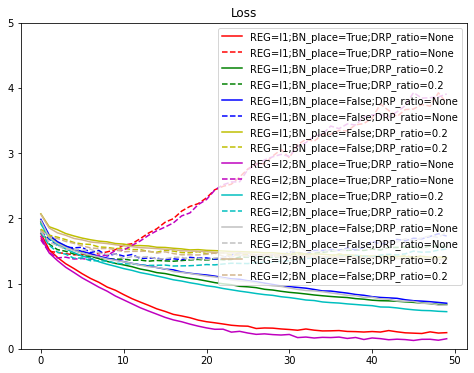

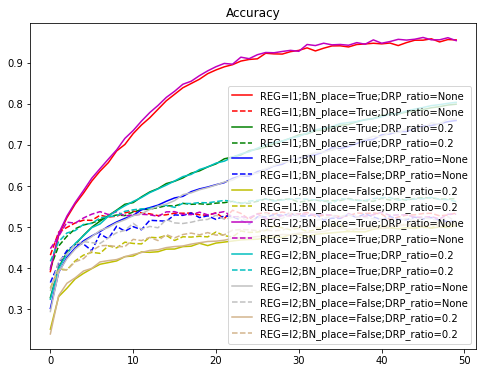

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "c", "silver", "tan", "orange"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()